# Imports

In [1]:
import sys
import tensorflow as tf
import numpy as np
import itertools
import os

import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path

import pandas as pd
import pyemma

sys.path.append('gmvae')
from model import GMVAE
from dataset import load_and_mix_data_nolabel

matplotlib.rcParams.update({'font.size': 24})

# Paths

In [2]:
readdir = 'data/'
savedir = 'results/'
modeldir = 'models/'

# Load data

In [3]:
data = np.load(readdir + "traj_mb.npy")
data_list = []
for i in range(data.shape[0]):
    data_list.append(data[i, :, :])
data = data.reshape(len(data)*10000, 2)
dataset = load_and_mix_data_nolabel(data=data, test_ratio=0.01)

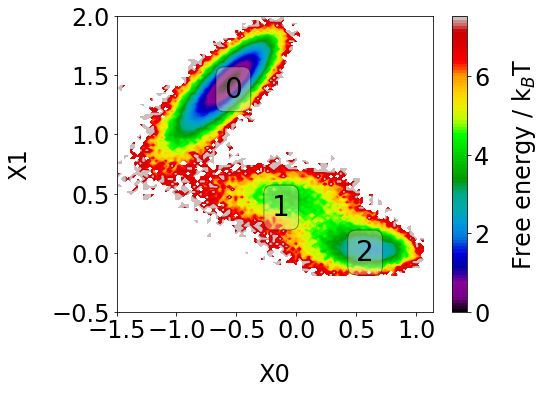

In [4]:
matplotlib.rcParams.update({'font.size': 24})
_, _, misc = pyemma.plots.plot_free_energy(data[:,0], data[:,1], nbins = 100, ncontours = 100, legacy = False)
cbar = misc['cbar']
cbar.set_label('Free energy / k$_{B}$T', labelpad=20)
cbar.set_ticks(np.arange(0, 8, 2))
fig = plt.gcf()
fig.set_size_inches(8, 6)
plt.xlabel('X0', labelpad=20)
plt.ylabel('X1', labelpad=20)
plt.yticks(np.arange(-0.5,2.1,0.5))
plt.xticks(np.arange(-1.5,1.5,0.5))
plt.text(-0.6, 1.5, '0', fontsize=28, verticalalignment='top', color='black', bbox=dict(facecolor='wheat', boxstyle='round', alpha=0.4))
plt.text(-0.2, 0.5, '1', fontsize=28, verticalalignment='top', color='black', bbox=dict(facecolor='wheat', boxstyle='round', alpha=0.4))
plt.text(0.5, 0.12, '2', fontsize=28, verticalalignment='top', color='black', bbox=dict(facecolor='wheat', boxstyle='round', alpha=0.4))
plt.tight_layout()
plt.savefig(savedir + 'FE.png')

# Training

In [5]:
k, n_x, n_z, n_epochs = 5, 2, 1, 401
qy_dims = [32]
qz_dims = [16]
pz_dims = [16]
px_dims = [128]
r_nent = 0.05
batch_size = 5000
lr = 1e-4

model_path = modeldir + 'model_' +str(k)+'_'+str(n_z)+'_'+str(n_epochs)+'_'+str(r_nent)+'_' + str(batch_size)
results = '_results'

if not os.path.exists(model_path):
    os.makedirs(model_path)

results_dir_s = model_path+results

if not os.path.exists(results_dir_s):
    os.makedirs(results_dir_s)
    
results_dir = Path(results_dir_s)
    
model = GMVAE(model_path, k=k, n_x=n_x, n_z=n_z, qy_dims = qy_dims,
              qz_dims = qz_dims, pz_dims = pz_dims, px_dims = px_dims,
              r_nent = r_nent, batch_size=batch_size, lr=lr)
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    history, ye, ze = model.train(dataset, sess, epochs=n_epochs,
                                  n_train_eval=200000, n_test_eval=200000, save_parameters=True, 
                                  is_labeled=False, track_losses=True, verbose=True)
    
f = open(model_path + '/training_params.txt','w+')
f.write(f'k={k}, n_x={n_x}, n_z={n_z}, n_epochs={n_epochs}, qy_dims={qy_dims}, qz_dims={qz_dims}, '+
        f'pz_dims={pz_dims}, px_dims={px_dims}, r_ent={r_nent}, batch_size={batch_size}, lr={lr}')
raw_data = {'k': [k], 'n_x': [n_x], 'n_z': [n_z], 'n_epochs': [n_epochs], 'qy_dims': [qy_dims], 'qz_dims': [qz_dims], 'pz_dims': [pz_dims], 
            'px_dims': [px_dims], 'r_nent': [r_nent], 'batch_size': [batch_size], 'lr': [lr]}
df = pd.DataFrame(data=raw_data)
df.to_pickle(model_path + '/training_params.pkl')
f.close()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
graph written
    tr_ent,   tr_loss,     t_ent,    t_loss,     epoch                                              
  1.56e+00,  4.68e+00,  1.55e+00,  4.57e+00,         1
Sample of qy
0.16 0.16 0.16 0.22 0.28 
0.20 0.20 0.20 0.20 0.21 
0.14 0.14 0.14 0.22 0.35 
0.15 0.15 0.15 0.23 0.32 
0.15 0.15 0.15 0.23 0.33 

epoch:         50                                                                                   
    tr_ent,   tr_loss,     t_ent,    t_loss,     epoch                                              
  2.00e-01,  9.94e-01,  1.89e-01,  9.74e-01,        51
Sample of qy
0.00 0.00 0.00 0.00 0.99 
0.03 0.37 0.13 0.45 0.02 
0.00 0.00 0.00 0.00 1.00 
0.00 0.00 0.00 0.00 0.99 
0.00 0.00 0.00 0.00 1.00 

epoch:        100                                                                                   
    tr_ent,   tr_loss,     t_ent,    t_loss,     epoch          

Training curve

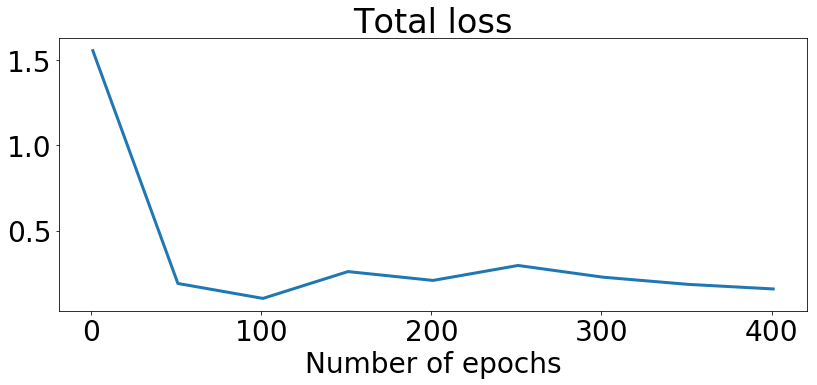

In [10]:
fig, axes = plt.subplots(figsize = (12,6), nrows=1, ncols=1)
axes.plot(history['iters'], history['val_ent'], linewidth = 3.0)
axes.set_title('Total loss')
axes.set_xlabel('Number of epochs')
plt.tight_layout() 
plt.savefig(str(results_dir) + 'training.png')
plt.show()

# Encodings

In [11]:
qy = model.encode_y(data)
y_pred = np.argmax(qy, axis=1)
z = model.encode_z(data)

INFO:tensorflow:Restoring parameters from models/model_5_1_401_0.05_5000\model.ckpt-401
INFO:tensorflow:Restoring parameters from models/model_5_1_401_0.05_5000\model.ckpt-401
INFO:tensorflow:Restoring parameters from models/model_5_1_401_0.05_5000\model.ckpt-401


In [12]:
np.unique(y_pred)

array([0, 1, 2, 3, 4], dtype=int64)

Distribution of z

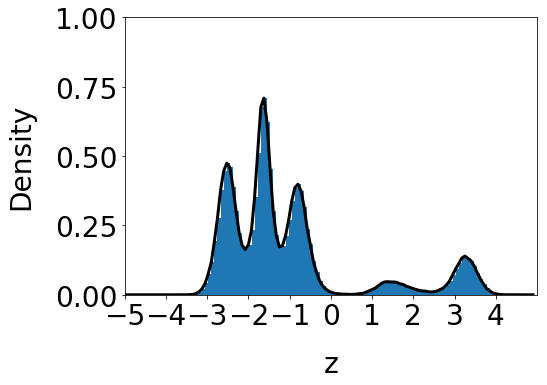

In [13]:
matplotlib.rcParams.update({'font.size': 28})
plt.figure(figsize=(8,6))
_ = plt.hist(z, bins= np.arange(-5, 5, 0.075), density=True)
ah = np.histogram(z, bins= np.arange(-5, 5, 0.075), density=True)
plt.plot(ah[1][:-1], ah[0], linewidth=3, color='k')
plt.ylabel('Density', labelpad=20)
plt.xlabel('z', labelpad=20)
plt.xticks(np.arange(-5, 5))
plt.xlim([-5,5])
plt.ylim([0, 1])
titlename = 'z_histograms_line'
plt.tight_layout()
plt.savefig(str(results_dir) + '/z_histogram.png', bbox_inches='tight')

GMVAE clusters on the FEL

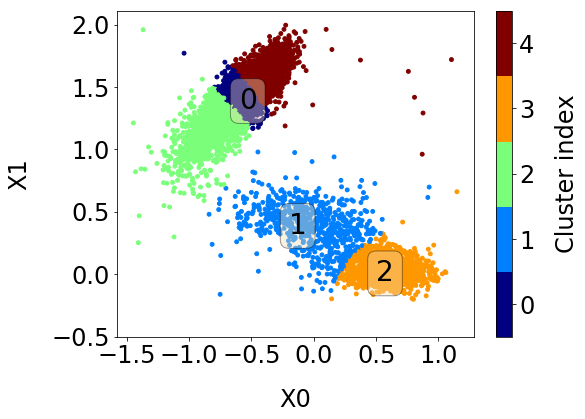

In [20]:
matplotlib.rcParams.update({'font.size': 24})
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
i=0
step=20
sc = axes.scatter(data[::step,0], data[::step,1], c=y_pred[::step], alpha=1, 
                  cmap=plt.cm.get_cmap('jet', len(np.unique(y_pred))), s=15)
cbar = fig.colorbar(sc, ax=axes)
cbar.set_alpha(1)
cbar.set_ticks(np.arange(0, 5, 1))
cbar.set_label('Cluster index', labelpad=20)
sc.set_alpha(1)
sc.set_clim(-0.5, len(np.unique(y_pred)) - 0.5)
cbar.draw_all()

axes.set_xlabel('X0', labelpad=20)
axes.set_ylabel('X1', labelpad=20)
axes.set_yticks(np.arange(-0.5,2.1,0.5))
axes.set_xticks(np.arange(-1.5,1.5,0.5))

axes.text(-0.6, 1.5, '0', fontsize=28, verticalalignment='top', color='black', bbox=dict(facecolor='wheat', boxstyle='round', alpha=0.4))
axes.text(-0.2, 0.5, '1', fontsize=28, verticalalignment='top', color='black', bbox=dict(facecolor='wheat', boxstyle='round', alpha=0.4))
axes.text(0.5, 0.12, '2', fontsize=28, verticalalignment='top', color='black', bbox=dict(facecolor='wheat', boxstyle='round', alpha=0.4))
fig.savefig(str(results_dir) + '/GMVAE_clusters.png', bbox_inches='tight')

Reconstructions

INFO:tensorflow:Restoring parameters from models/model_5_1_401_0.05_5000\model.ckpt-401
INFO:tensorflow:Restoring parameters from models/model_5_1_401_0.05_5000\model.ckpt-401


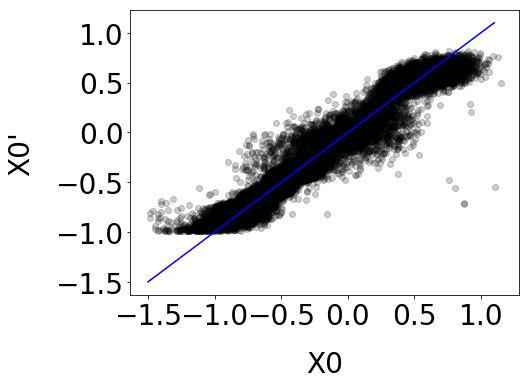

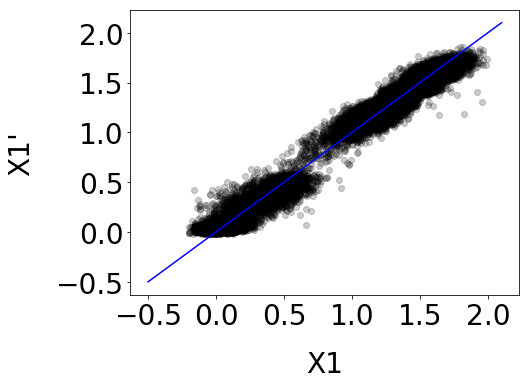

In [15]:
matplotlib.rcParams.update({'font.size': 28})

plt.figure(figsize=(8,6))
x = model.reconstruct(data)
plt.scatter(data[::5,0], x[::5,0], color = 'k', alpha=0.2)
plt.xlabel("X0", labelpad=20)
plt.ylabel("X0'", labelpad=20)
lims = [-1.5, 1.1]
plt.plot(lims, lims, 'b-', alpha=1)
plt.xticks(np.arange(-1.5, 1.1, step=0.5))
plt.yticks(np.arange(-1.5, 1.1, step=0.5))
plt.tight_layout()
plt.savefig(str(results_dir) + '/reconst_X0.png')

plt.figure(figsize=(8,6))
plt.scatter(data[::5,1], x[::5,1], color = 'k', alpha=0.2)
plt.xlabel("X1", labelpad=20)
plt.ylabel("X1'", labelpad=20)
lims = [-0.5, 2.1]
plt.plot(lims, lims, 'b-', alpha=1)
plt.xticks(np.arange(-0.5, 2.1, step=0.5))
plt.yticks(np.arange(-0.5, 2.1, step=0.5))
plt.tight_layout()
plt.savefig(str(results_dir) + '/reconst_X1.png')


# MSM Analysis

Convert cluster data into list

In [16]:
y_pred_list = []
for i in range(30):
    y_pred_list.append(y_pred[i*10000: (i+1)*10000])

Implied timescale test

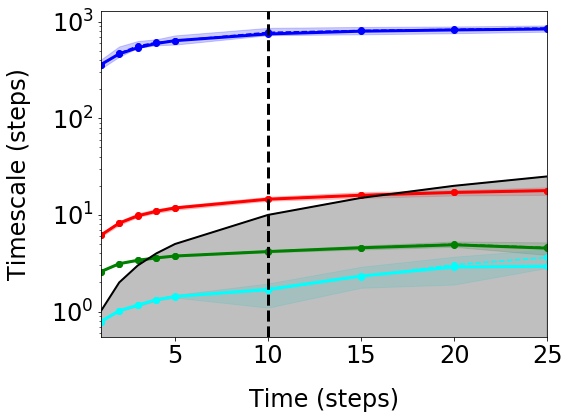

In [17]:
plt.rcParams.update({'font.size': 24})
cklag = 10
its = pyemma.msm.its(y_pred_list, lags=[1, 2, 3, 4, 5, 10, 15, 20, 25], errors='bayes')
fig, axes = plt.subplots(nrows=1, ncols = 1, figsize=(8,6))
pyemma.plots.plot_implied_timescales(its, marker = 'o', ylog=True, units='steps', ax = axes, linewidth=3)
axes.axvline(cklag, color ='black', linewidth = 3, linestyle='--'  )
titlename = "its"
axes.set_xlabel('Time (steps)', labelpad=20)
axes.set_ylabel('Timescale (steps)', labelpad=20)
fig.savefig(str(results_dir) + '/its.png', bbox_inches='tight')

Chapman-Kolmogorov test

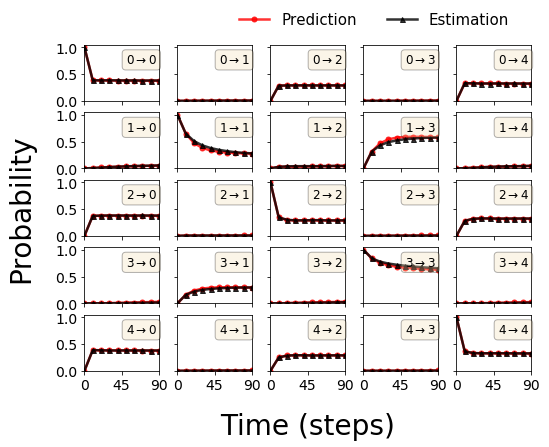

In [24]:
cklag =10
nc = 5
matplotlib.rcParams.update({'font.size': 14})
msm = pyemma.msm.estimate_markov_model(y_pred_list, lag=cklag, dt_traj='1 ps')
cktestobj = msm.cktest(nc, memberships =np.eye(nc))
fig, axes = plt.subplots(figsize=(8,6), nrows=nc, ncols=nc, sharex = True, sharey=True)
axes=axes.ravel()
xlimits=[0, cklag*9]
props = dict(boxstyle='round', facecolor='wheat', alpha=0.3)

for k in range(nc**2):
    j=k%nc
    i=k//nc
    axes[k].plot(cktestobj.lagtimes, cktestobj.predictions[:, i, j], color='red',
                 linewidth=2.5, alpha = 0.8, marker='o', markersize=5, linestyle='-', label='Prediction')
    axes[k].plot(cktestobj.lagtimes, cktestobj.estimates[:, i, j], color='black',
                 linewidth=2.5, alpha = 0.8, marker="^", markersize=5, label='Estimation')
    axes[k].text(cklag*5, 0.7, str(i)+r'$\rightarrow$'+str(j), fontsize=12, bbox=props)
    axes[k].set_ylim([0, 1.05])
    axes[k].set_xlim([0, cklag*9])
    axes[k].set_xticks(np.arange(xlimits[0], xlimits[1]+0.1, xlimits[1]//2, dtype='int'))
    axes[k].set_yticks(np.arange(0, 1.01, 0.5))
titlename = "ck_test"
plt.legend( loc = [-3, 6], ncol=2, frameon=False, fontsize=15)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor= 'none', top=False, bottom=False, left=False, right=False)
plt.xlabel('Time (steps)', fontsize=28, labelpad=20)
plt.ylabel('Probability', labelpad = 20, fontsize=28)
plt.grid(False)
plt.subplots_adjust(wspace=0.25)
fig.savefig(str(results_dir)+'/gmvae_ck.png', bbox_inches='tight')